In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Load dataset
# Assuming '.csv' has multiple columns, where the last column is the energy consumption to predict
df = pd.read_csv('/content/sample_data/Household electricity dataset.csv')
df.drop('Date', axis=1, inplace=True)
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(df)

# Convert series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # Concatenate
    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    # Prepare X and y
    X, y = agg.iloc[:, :-n_vars], agg.iloc[:, -n_vars:]
    return X.values, y.values

# Frame as supervised learning
n_lag = 3
X, y = series_to_supervised(data_normalized, n_lag, 1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], n_lag, -1)
X_test = X_test.reshape(X_test.shape[0], n_lag, -1)

# Define BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Predict
y_pred = model.predict(X_test)
y_pred_original_scale = scaler.inverse_transform(y_pred)

# You can then compare `y_pred_original_scale` with the actual energy consumption from `y_test`


Epoch 1/100
33/33 [==============================] - 3s 18ms/step - loss: 0.1492 - val_loss: 0.0391
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0345 - val_loss: 0.0319
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0297 - val_loss: 0.0281
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0263 - val_loss: 0.0254
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0241 - val_loss: 0.0244
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0230 - val_loss: 0.0229
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0219 - val_loss: 0.0219
Epoch 8/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0211 - val_loss: 0.0211
Epoch 9/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0205 - val_loss: 0.0208
Epoch 10/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0200 - val_loss: 0.0204
Epoch 1

Epoch 1/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0108 - val_loss: 0.0131
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0131
Epoch 3/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0110 - val_loss: 0.0131
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0127
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0127
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0134
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0128
Epoch 8/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0132
Epoch 9/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0129
Epoch 10/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0129
Epoch 11

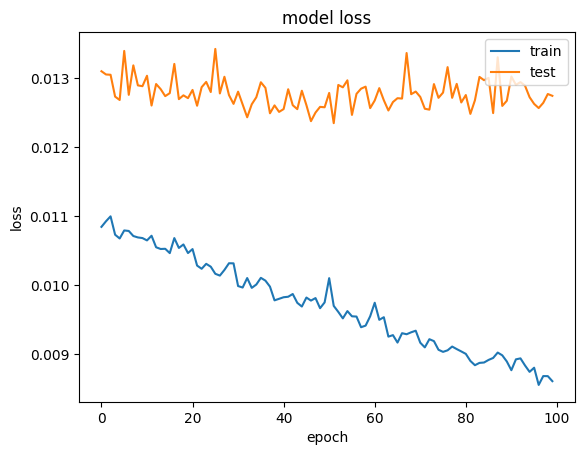

In [ ]:
import matplotlib.pyplot as plt
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()